In [1]:
import sys
sys.path.append("/home/sergey/tools/scLiTr/")
import sclitr as sl

import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sc.set_figure_params(dpi=120)
sns.set_style("ticks")

sc.settings.figdir = "figures_comparison"
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [2]:
adata = sc.read_h5ad("technical_supplementary/data/Weinreb_in_vitro.h5ad")
clones = sc.read_h5ad("/home/sergey/disk/Weinreb_clones_pred.h5ad")

In [2]:
!scp technical_supplementary/data/Weinreb_in_vitro.h5ad Jupiter:/home/sergey/projects/clonal_project/
!scp /home/sergey/disk/Weinreb_clones_pred.h5ad Jupiter:/home/sergey/projects/clonal_project/

Weinreb_in_vitro.h5ad                         100% 1455MB 107.3MB/s   00:13    
Weinreb_clones_pred.h5ad                      100% 2507KB  33.9MB/s   00:00    


In [ ]:
shapdata_c2v = sl.tl.predict_c2v(
    adata,
    clones,
    clone_col="Clone",
    ct_col="Cell type annotation short",
    use_gpu=True,
    verbose=True,
    limit_ct="Undiff",
    use_ct=False,
    pseudobulk=False,
)

Some of the clones doesn't contain cell type of interest. Putting the result of prediction in the uns.


In [4]:
shapdata_ct = sl.tl.predict_ct(
    adata,
    clones,
    clone_col="Clone",
    ct_col="Cell type annotation short",
    use_gpu=True,
    verbose=True,
    limit_ct="Undiff",
    use_ct=False,
    pseudobulk=False,
    ct_layer="frequencies",
)

/home/sergey/tools/scLiTr/sclitr/utils.py:233: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr = expr.groupby(["celltype_column", "clone_column"]).mean().reset_index().dropna()


Learning rate set to 0.025809
0:	learn: 0.6462102	test: 0.6459618	best: 0.6459618 (0)	total: 363ms	remaining: 1h 33s
1:	learn: 0.6037646	test: 0.6027518	best: 0.6027518 (1)	total: 655ms	remaining: 54m 36s
2:	learn: 0.5641102	test: 0.5646523	best: 0.5646523 (2)	total: 960ms	remaining: 53m 19s
3:	learn: 0.5276569	test: 0.5284139	best: 0.5284139 (3)	total: 1.27s	remaining: 53m 3s
4:	learn: 0.4954905	test: 0.4964668	best: 0.4964668 (4)	total: 1.57s	remaining: 52m 14s
5:	learn: 0.4666587	test: 0.4678684	best: 0.4678684 (5)	total: 1.86s	remaining: 51m 42s
6:	learn: 0.4393067	test: 0.4408461	best: 0.4408461 (6)	total: 2.17s	remaining: 51m 38s
7:	learn: 0.4145679	test: 0.4163170	best: 0.4163170 (7)	total: 2.46s	remaining: 51m 18s
8:	learn: 0.3918817	test: 0.3936878	best: 0.3936878 (8)	total: 2.75s	remaining: 50m 49s
9:	learn: 0.3720591	test: 0.3742422	best: 0.3742422 (9)	total: 3.05s	remaining: 50m 51s
10:	learn: 0.3533591	test: 0.3561078	best: 0.3561078 (10)	total: 3.36s	remaining: 50m 49s
11

In [12]:
clones_predicted = sc.AnnData(
    X=clones.uns["ct_predicted"],
    obs=pd.DataFrame(index=clones.uns["ct_predicted_names"]),
    var=pd.DataFrame(index=clones.var_names),
    obsm={
        "clone2vec_predicted": pd.DataFrame(
            clones.uns["clone2vec_predicted"],
            index=clones.uns["clone2vec_predicted_names"]
        ).loc[clones.uns["ct_predicted_names"]].values,
        "clone2vec": clones[
            clones.uns["ct_predicted_names"]
        ].obsm["clone2vec"],
    },
    layers={
        "ground_truth_proportions": clones[
            clones.uns["ct_predicted_names"]
        ].layers["frequencies"],
        "ground_truth_counts": clones[
            clones.uns["ct_predicted_names"]
        ].layers["counts"],
    }
)

# clones_predicted.write_h5ad("/home/sergey/disk/Weinreb_clones_pred_only.h5ad")

In [7]:
clones_predicted

AnnData object with n_obs × n_vars = 2556 × 11
    obsm: 'clone2vec_predicted', 'clone2vec'
    layers: 'ground_truth_proportions', 'ground_truth_counts'

In [248]:
def cross_entropy(predictions, targets, epsilon=1e-8):
    predictions = np.clip(predictions, epsilon, 1-epsilon)
    return (-np.log(predictions) * targets).sum(axis=1).mean()

In [249]:
cross_entropy_prop = cross_entropy(
    clones_predicted.X,
    clones_predicted.layers["ground_truth_proportions"],
)

print(cross_entropy_prop)

0.6158022251805578


In [250]:
import pynndescent

index = pynndescent.NNDescent(clones_predicted.obsm["clone2vec"])
neighbors = index.query(clones_predicted.obsm["clone2vec_predicted"], k=10)[0]
clones_predicted.layers["clone2vec_predicted_c2v"] = np.array([
    clones[neighbors[i]].layers["counts"].mean(axis=0)
    for i in range(neighbors.shape[0])
])
clones_predicted.layers["clone2vec_predicted_c2v"] = (
    clones_predicted.layers["clone2vec_predicted_c2v"].T / 
    clones_predicted.layers["clone2vec_predicted_c2v"].sum(axis=1)
).T

In [254]:
import pynndescent

index = pynndescent.NNDescent(clones_predicted.obsm["clone2vec"])
neighbors = index.query(clones_predicted.obsm["clone2vec_predicted"], k=10)[0]
clones_predicted.layers["clone2vec_predicted_c2v"] = np.array([
    clones[neighbors[i]].layers["counts"].mean(axis=0)
    for i in range(neighbors.shape[0])
])
clones_predicted.layers["clone2vec_predicted_c2v"] = (
    clones_predicted.layers["clone2vec_predicted_c2v"].T / 
    clones_predicted.layers["clone2vec_predicted_c2v"].sum(axis=1)
).T

In [255]:
cross_entropy_prop = cross_entropy(
    clones_predicted.layers["clone2vec_predicted_c2v"],
    clones_predicted.layers["ground_truth_proportions"],
)

print(cross_entropy_prop)

2.1159038389352784


In [8]:
shapdata_ct.var["gene_importance"] = shapdata_ct.layers["shap"].mean(axis=0).A[0]
shapdata_ct.var.sort_values("gene_importance").tail(5)

gene_importance
Gstm1         0.295170
Elane         0.303318
Ly6a          0.367155
Cpa3          0.468718
Gata2         0.595465

In [13]:
shapdata_c2v.var["gene_importance"] = shapdata_c2v.layers["shap"].mean(axis=0).A[0]
shapdata_c2v.var.sort_values("gene_importance").tail(5)

gene_importance
Srgn          0.428674
Dlk1          0.435102
Gstm1         0.441677
Cybb          0.529867
Gata2         0.930520

In [14]:
df = pd.DataFrame({
    "clone2vec": shapdata_c2v.var["gene_importance"].loc[shapdata_ct.var_names],
    "cell_type": shapdata_ct.var["gene_importance"],
})

df["clone2vec"] = df.clone2vec / df.clone2vec.max() * 100
df["cell_type"] = df.cell_type / df.cell_type.max() * 100

Text(0, 0.5, 'clone2vec SHAP')

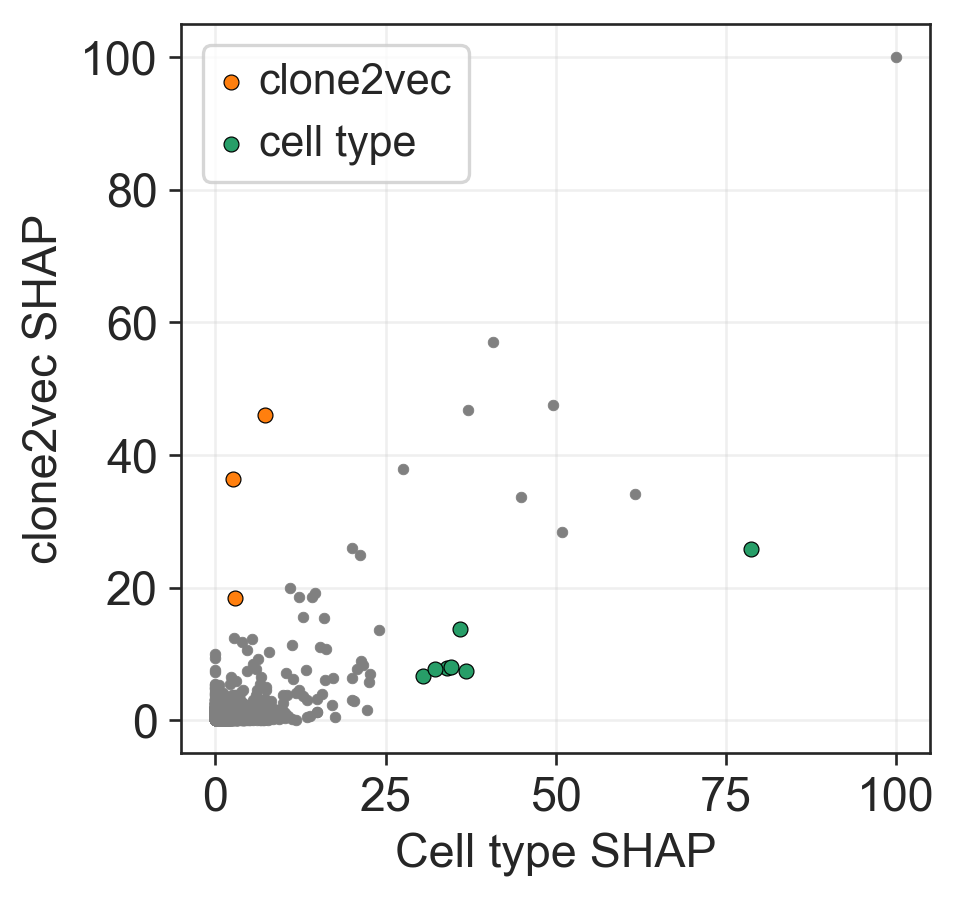

In [16]:
ax = sns.scatterplot(
    x=df.cell_type,
    y=df.clone2vec,
    s=10,
    edgecolor=None,
    color="grey",
)

c2v_more = df[
    (df.clone2vec / df.cell_type > 2) &
    (df.clone2vec > 18)
]
sns.scatterplot(
    x=c2v_more.cell_type,
    y=c2v_more.clone2vec,
    s=20,
    edgecolor="black",
    color=sns.color_palette()[1],
    label="clone2vec",
)

ct_more = df[
    (df.clone2vec / df.cell_type < 1/2) &
    (df.cell_type > 25)
]
sns.scatterplot(
    x=ct_more.cell_type,
    y=ct_more.clone2vec,
    s=20,
    edgecolor="black",
    color=sns.color_palette()[2],
    label="cell type",
)


ax.grid(alpha=0.3)
ax.set_xlabel("Cell type SHAP")
ax.set_ylabel("clone2vec SHAP")

In [17]:
from tqdm import tqdm

expr_matrix = shapdata_ct.X.A

for ct in tqdm(clones.var_names):
    shap_matrix = shapdata_ct.layers[f"shap_{ct}"].A
    correlations = []
    for i in range(expr_matrix.shape[1]):
        correlations.append(np.corrcoef(expr_matrix[:, i], shap_matrix[:, i])[0, 1])
    shapdata_ct.var[f"shap_corr_{ct}"] = correlations
    shapdata_ct.var[f"shap_corr_{ct}"] = shapdata_ct.var[f"shap_corr_{ct}"].fillna(0)

  0%|          | 0/11 [00:00<?, ?it/s]/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
  9%|▉         | 1/11 [00:05<00:58,  5.86s/it]/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 18%|█▊        | 2/11 [00:11<00:52,  5.79s/it]/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sergey/miniconda3/e

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/textalloc/__init__.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = ax.transData.transform((x[i], y[i]))
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/textalloc/__init__.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = ax.transData.transform((x[i], y[i]))
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/textalloc/__init__.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To ac

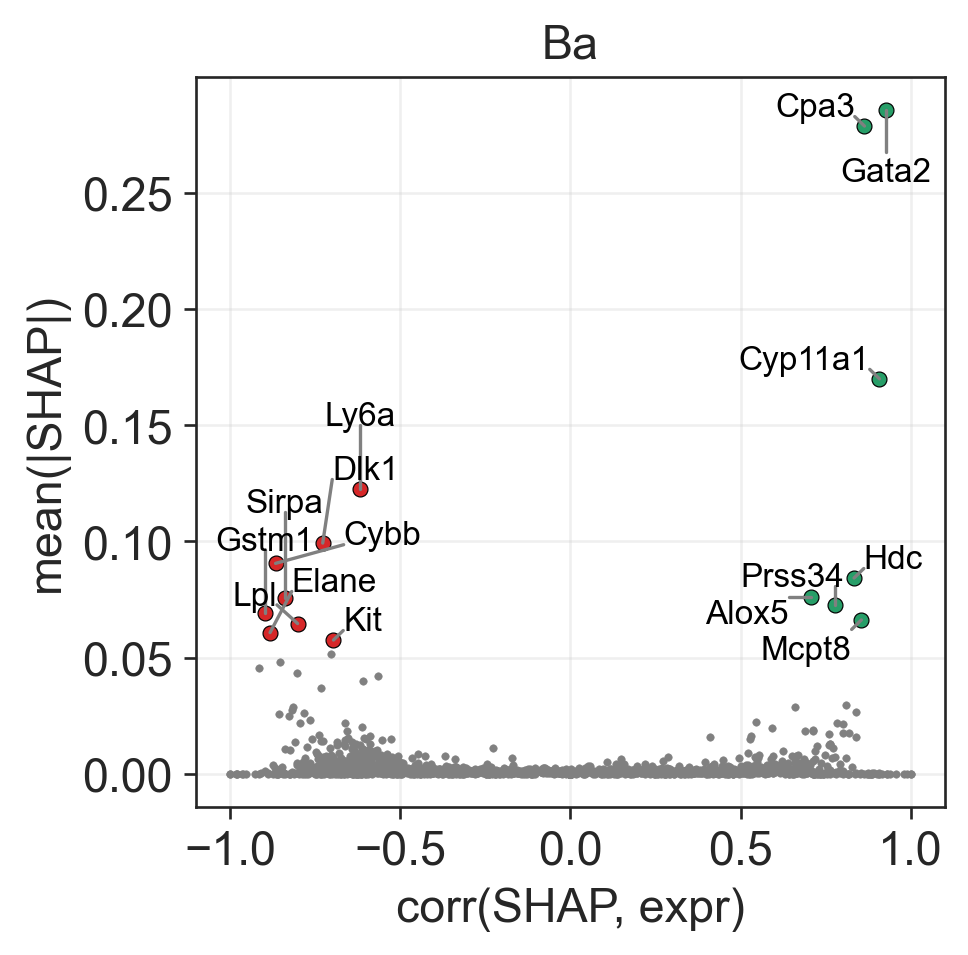

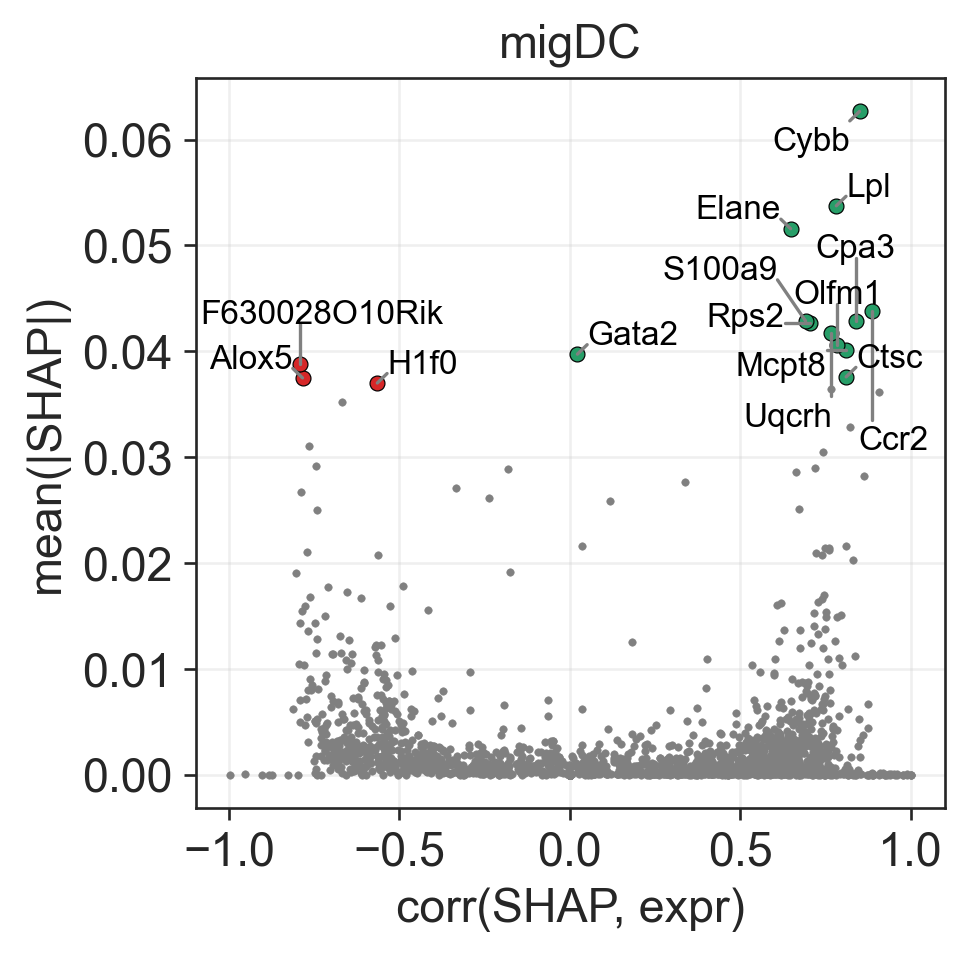

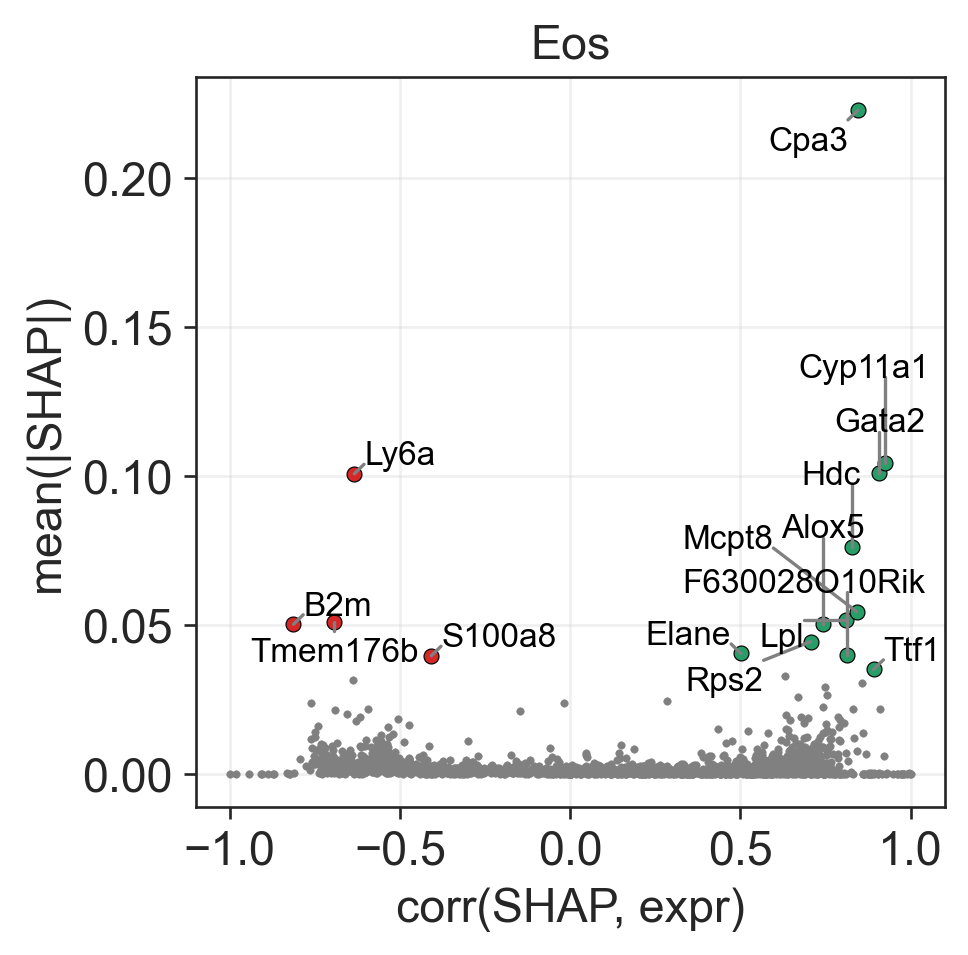

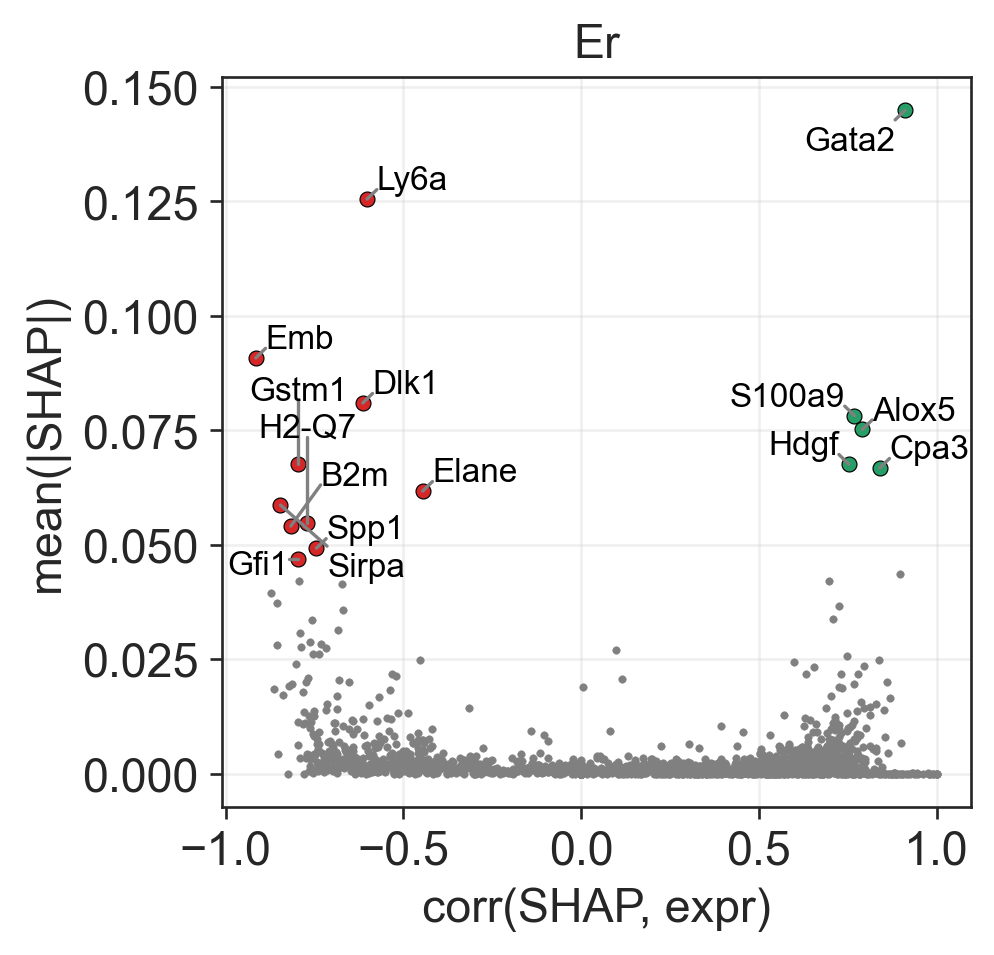

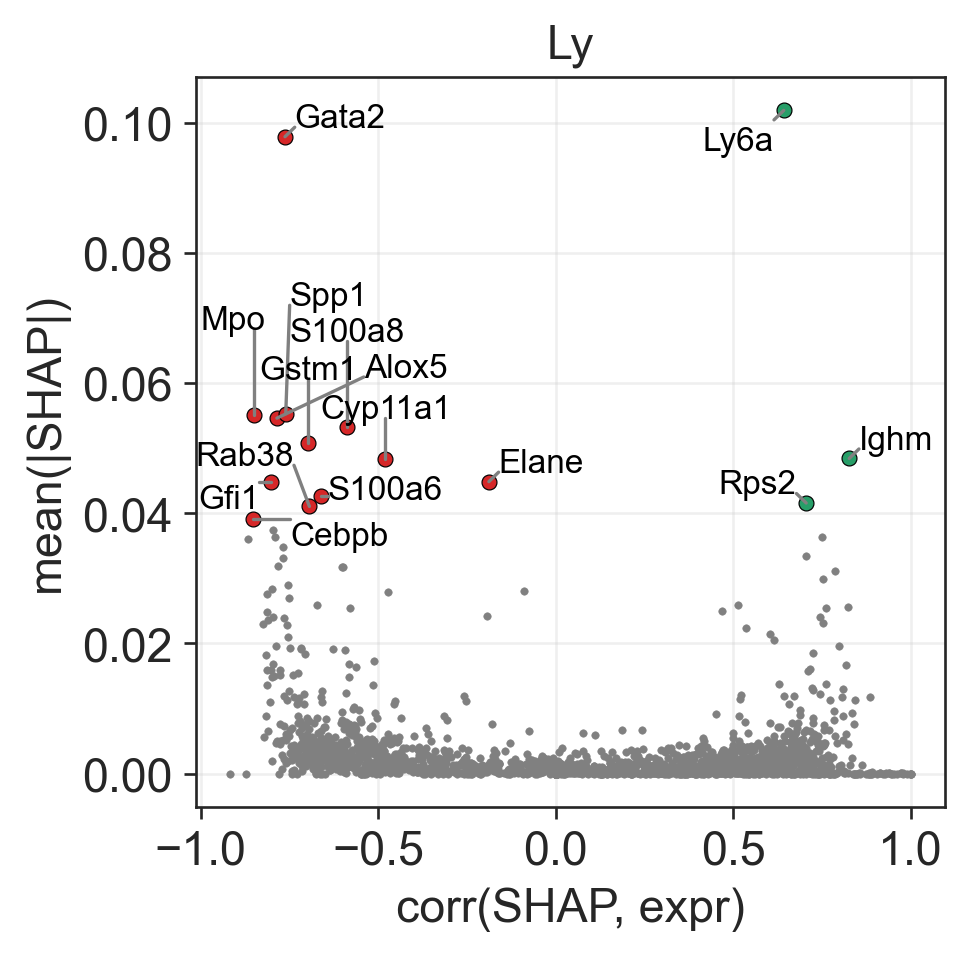

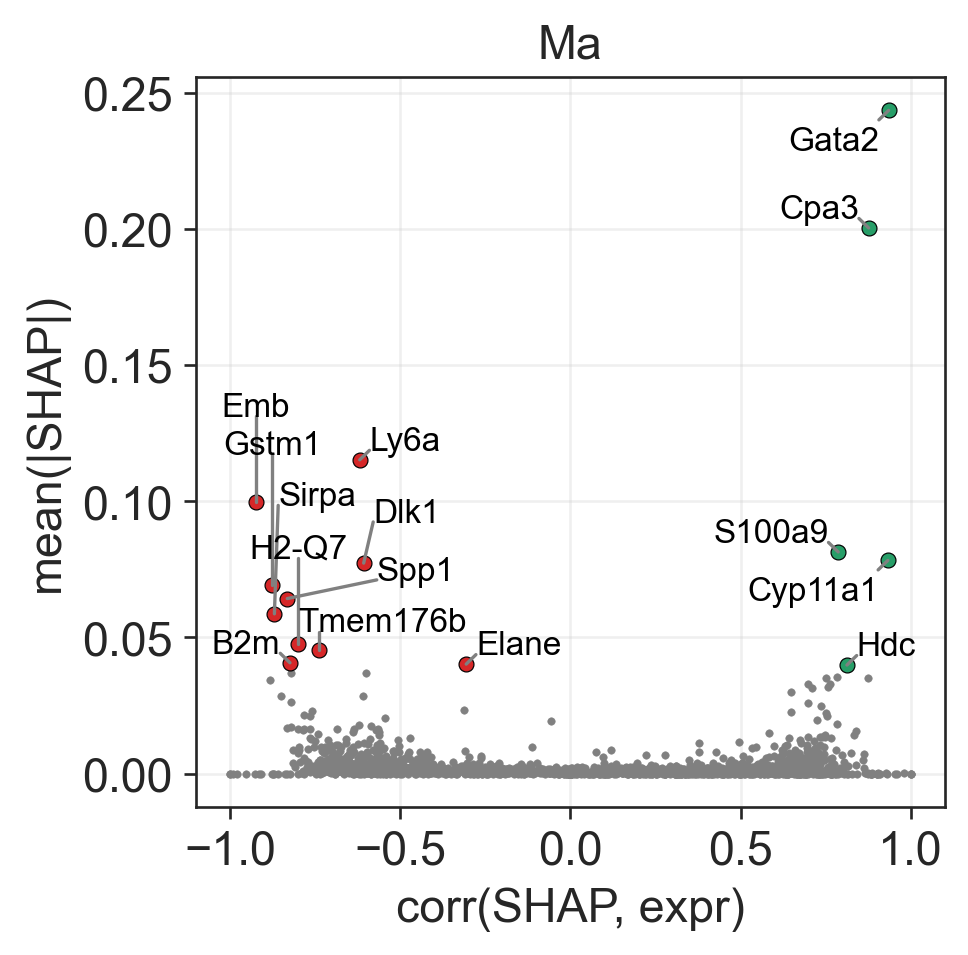

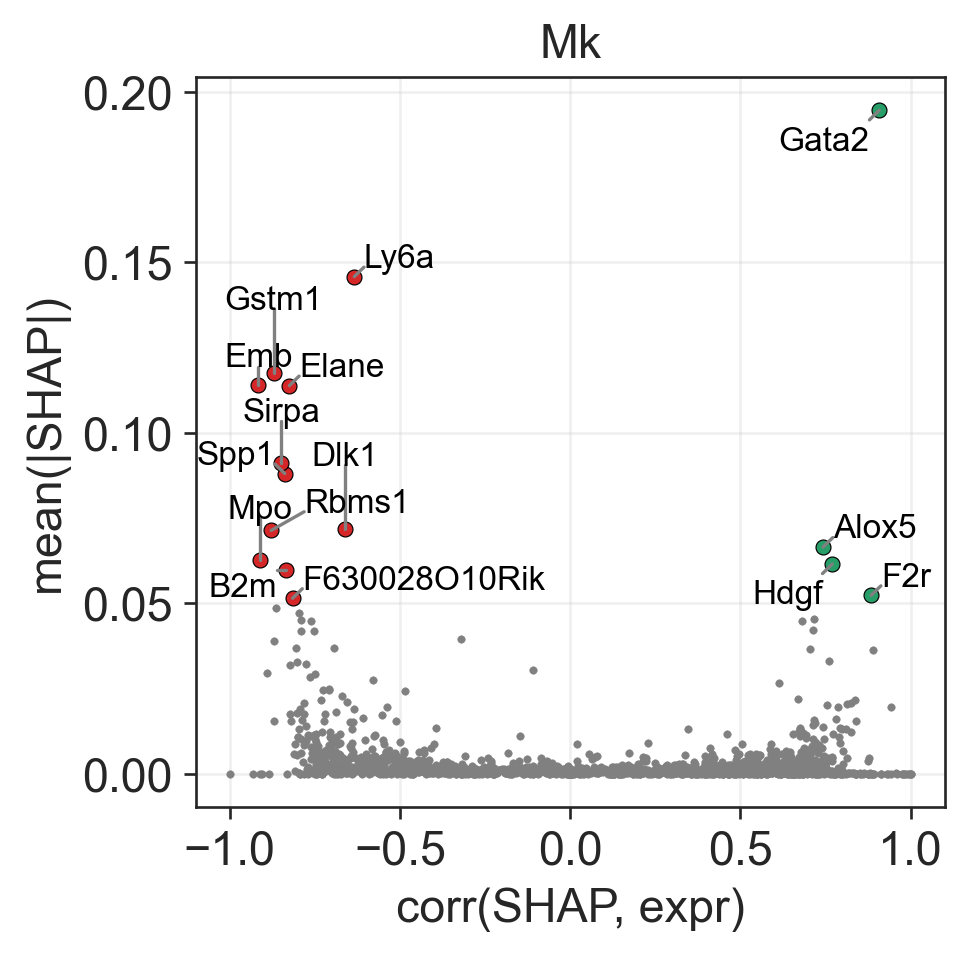

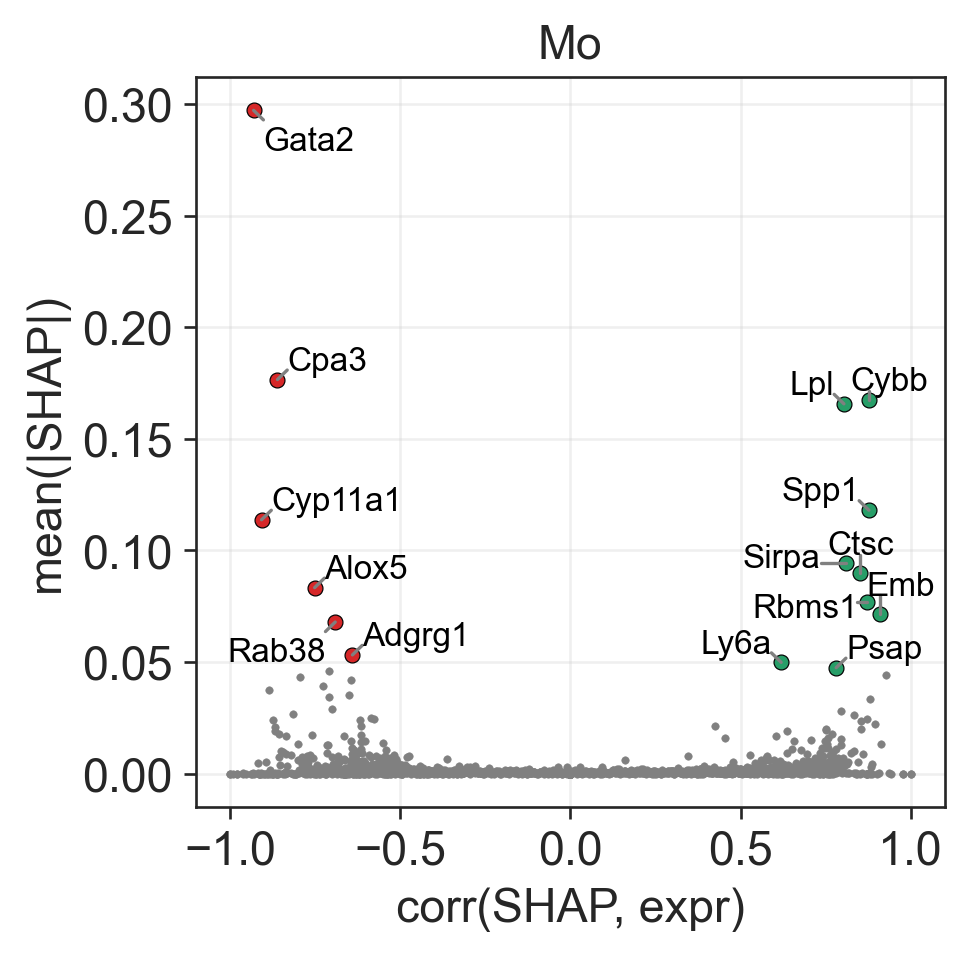

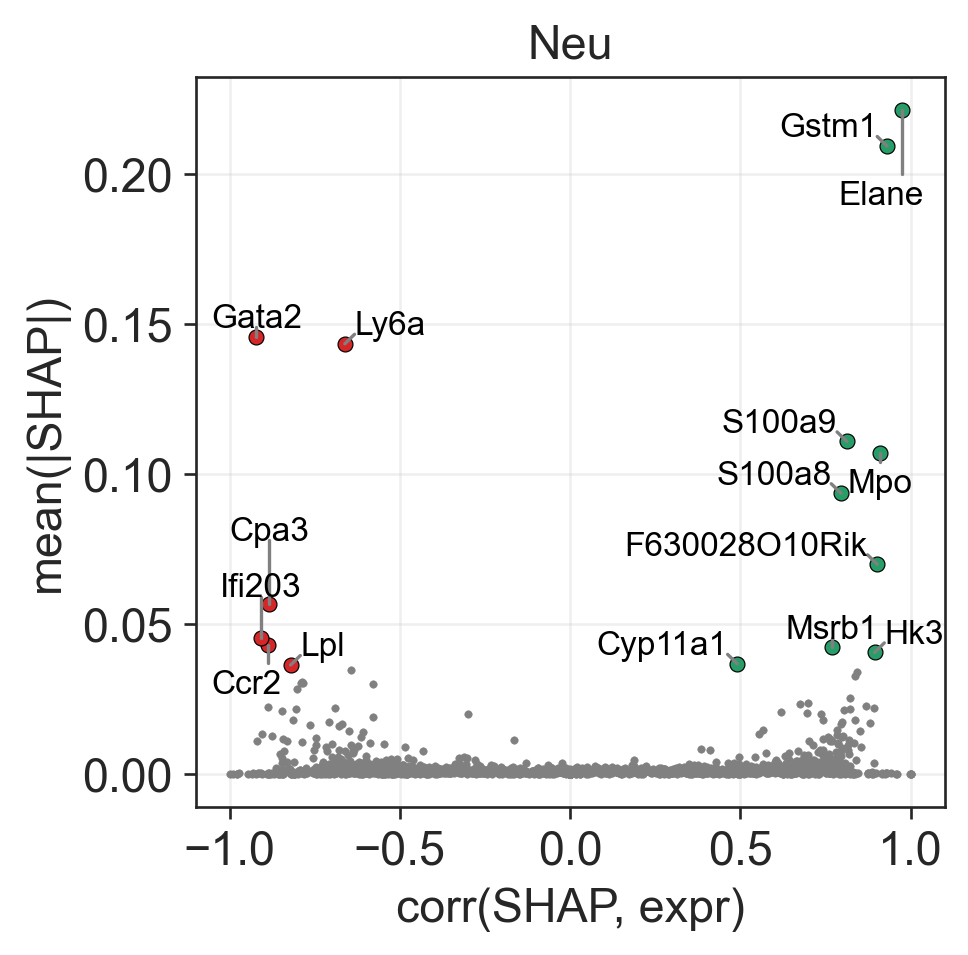

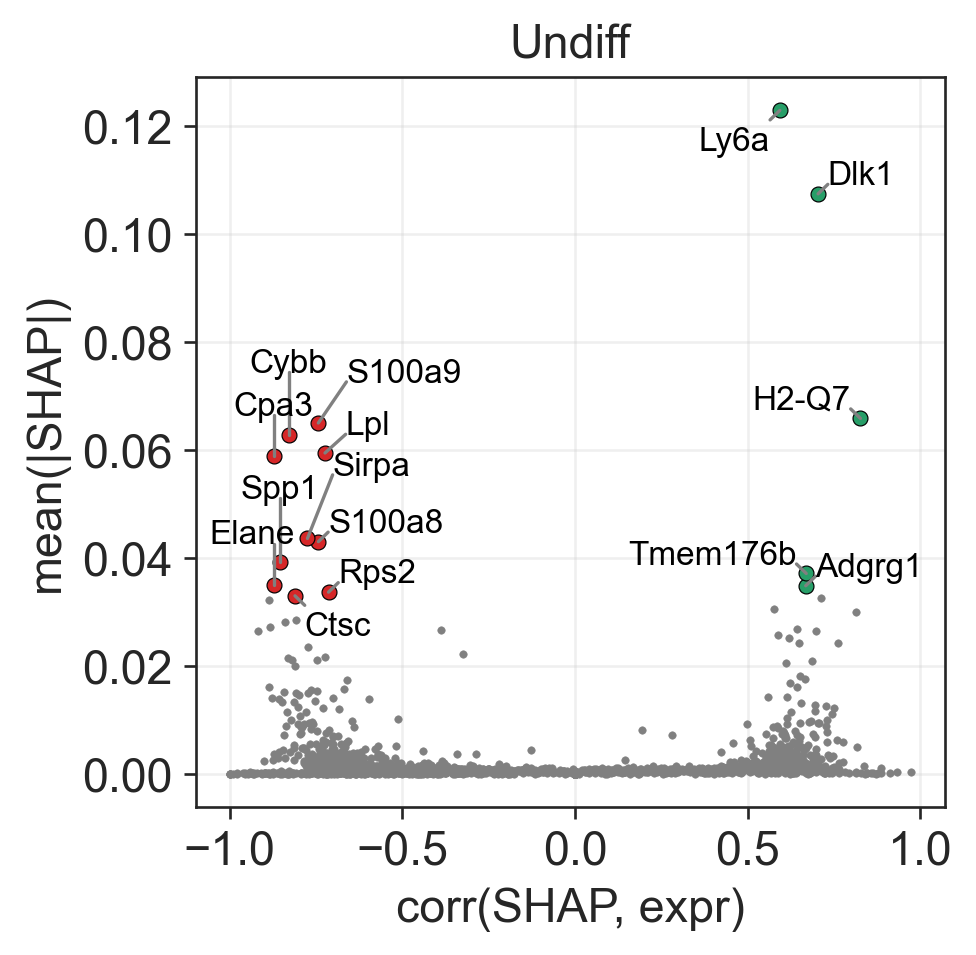

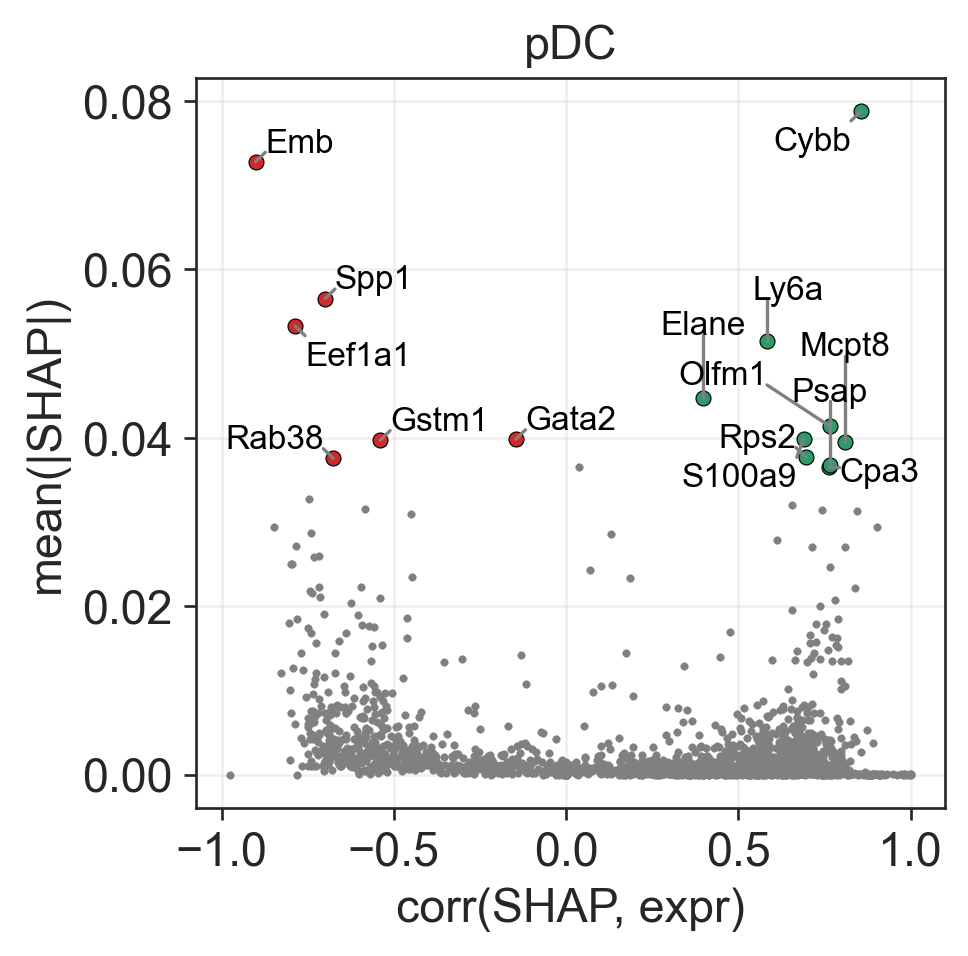

In [18]:


n_genes = 15

for ct in clones.var_names:
    fig, ax = plt.subplots(figsize=(4, 4))
    
    df = pd.DataFrame({
        "shap_correlation": shapdata_ct.var[f"shap_corr_{ct}"].values,
        "mean_shap_mag": np.abs(shapdata_ct.layers[f"shap_{ct}"]).mean(axis=0).A[0],
    }, index=shapdata_ct.var_names)

    sns.scatterplot(
        x="shap_correlation",
        y="mean_shap_mag",
        data=df,
        edgecolor=None,
        s=5,
        color="grey",
        ax=ax,
    )

    # Top-predictors
    df_subset = df.loc[df.mean_shap_mag.sort_values()[-n_genes:].index]
    sns.scatterplot(
        x="shap_correlation",
        y="mean_shap_mag",
        data=df_subset[df_subset.shap_correlation > 0],
        edgecolor="black",
        s=20,
        color=sns.color_palette()[2],
        ax=ax,
    )
    
    sns.scatterplot(
        x="shap_correlation",
        y="mean_shap_mag",
        data=df_subset[df_subset.shap_correlation < 0],
        edgecolor="black",
        s=20,
        color=sns.color_palette()[3],
        ax=ax,
    )
    
    ta.allocate(
        ax,
        x=df_subset.shap_correlation,
        y=df_subset.mean_shap_mag,
        text_list=df_subset.index,
        x_scatter=df.shap_correlation,
        y_scatter=df.mean_shap_mag,
        textsize=10,
        linecolor="grey",
    )

    ax.set_xlabel("corr(SHAP, expr)")
    ax.set_ylabel("mean(|SHAP|)")
    ax.grid(alpha=0.3)
    ax.set_title(ct)

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/textalloc/__init__.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = ax.transData.transform((x[i], y[i]))
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/textalloc/__init__.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = ax.transData.transform((x[i], y[i]))
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/textalloc/__init__.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To ac

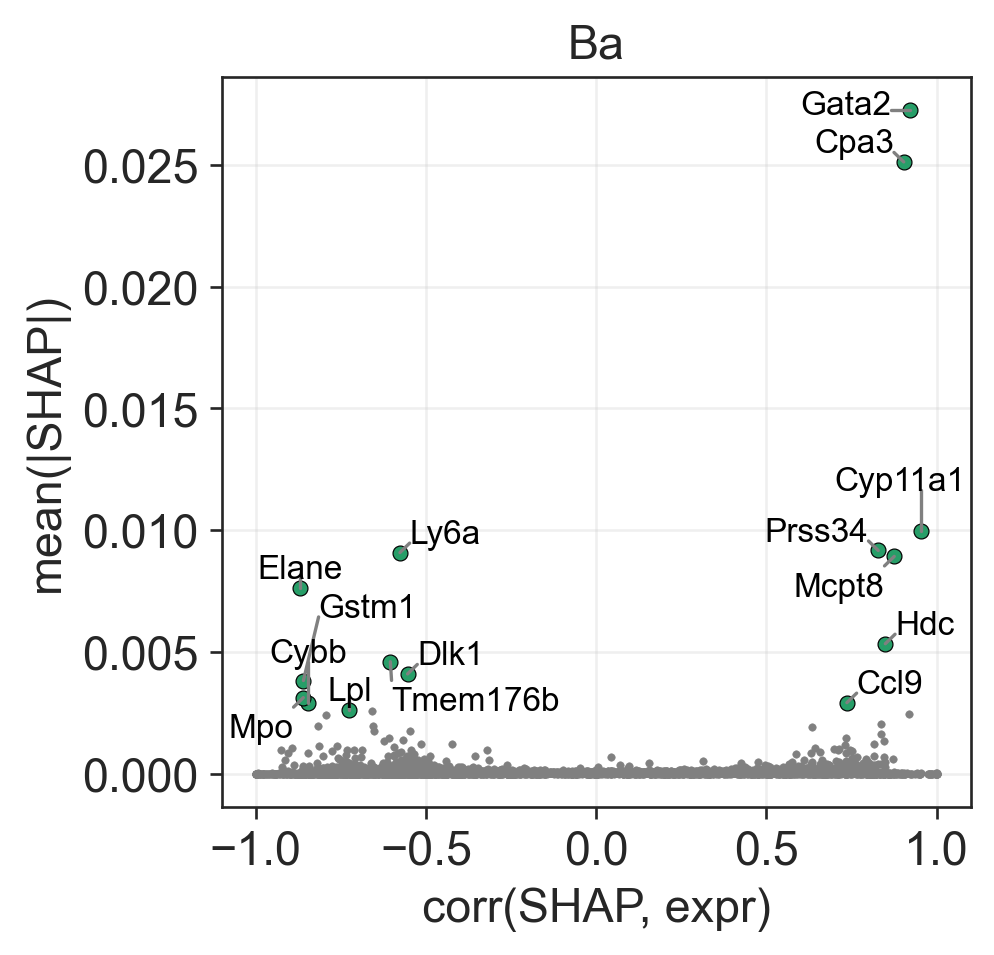

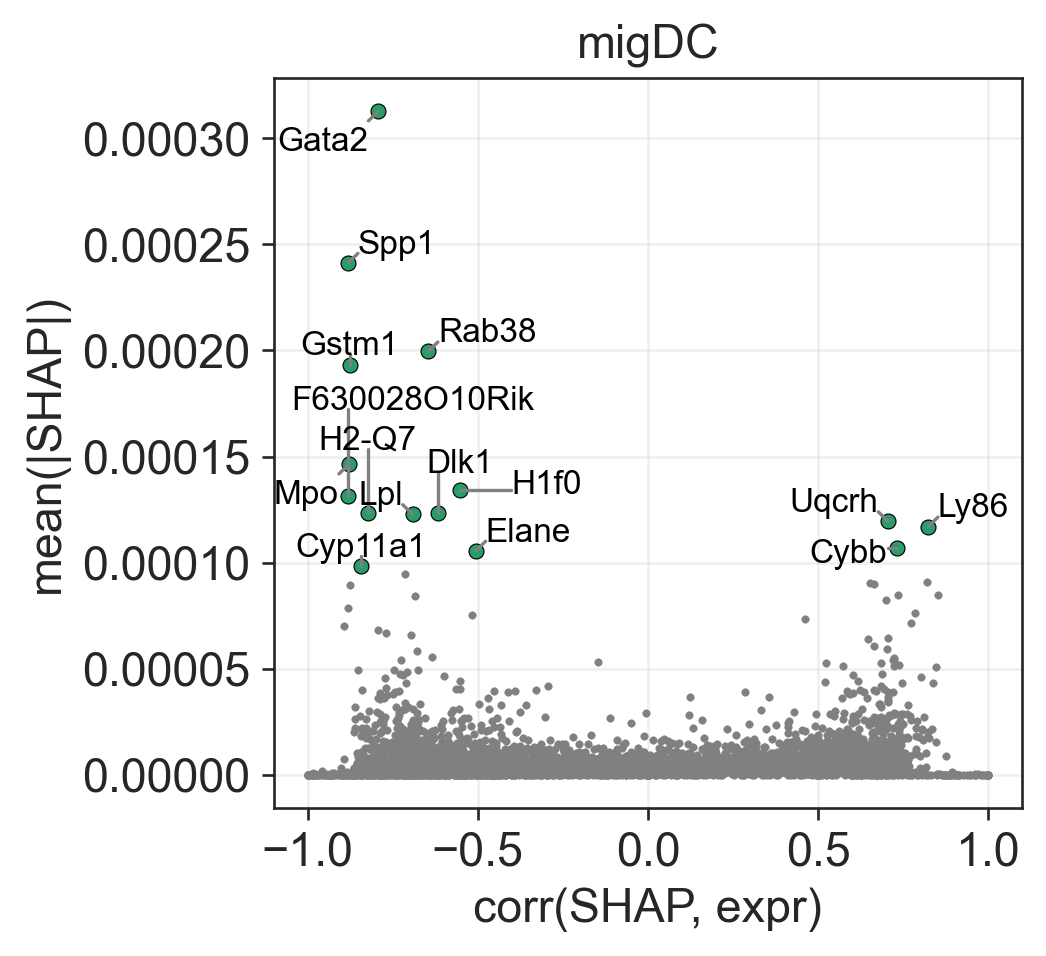

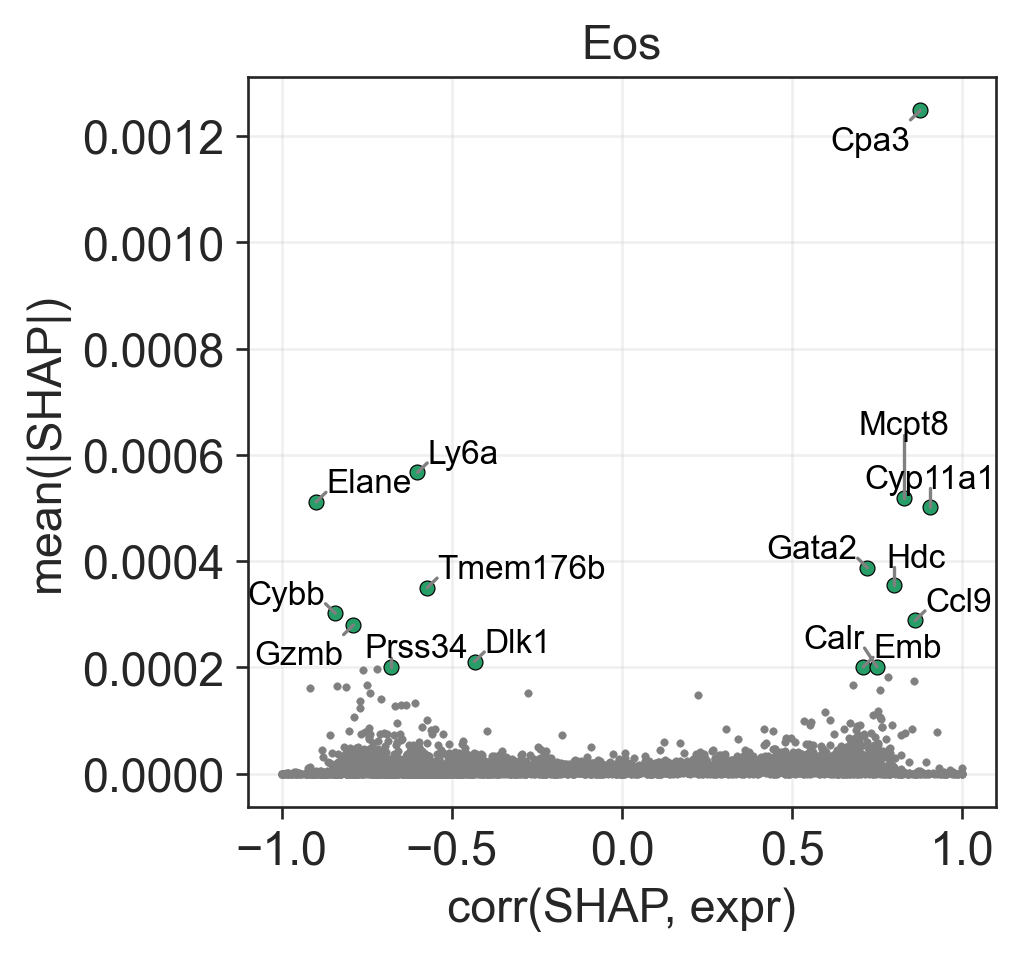

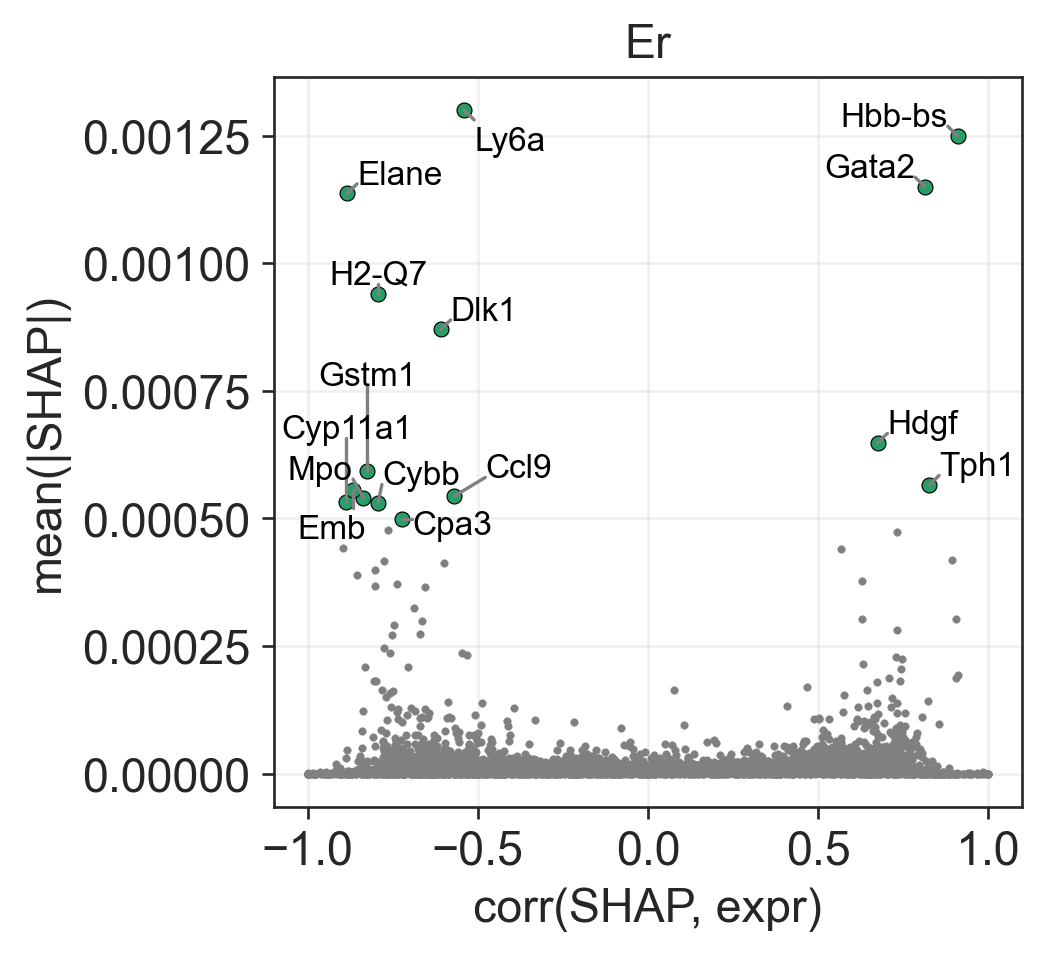

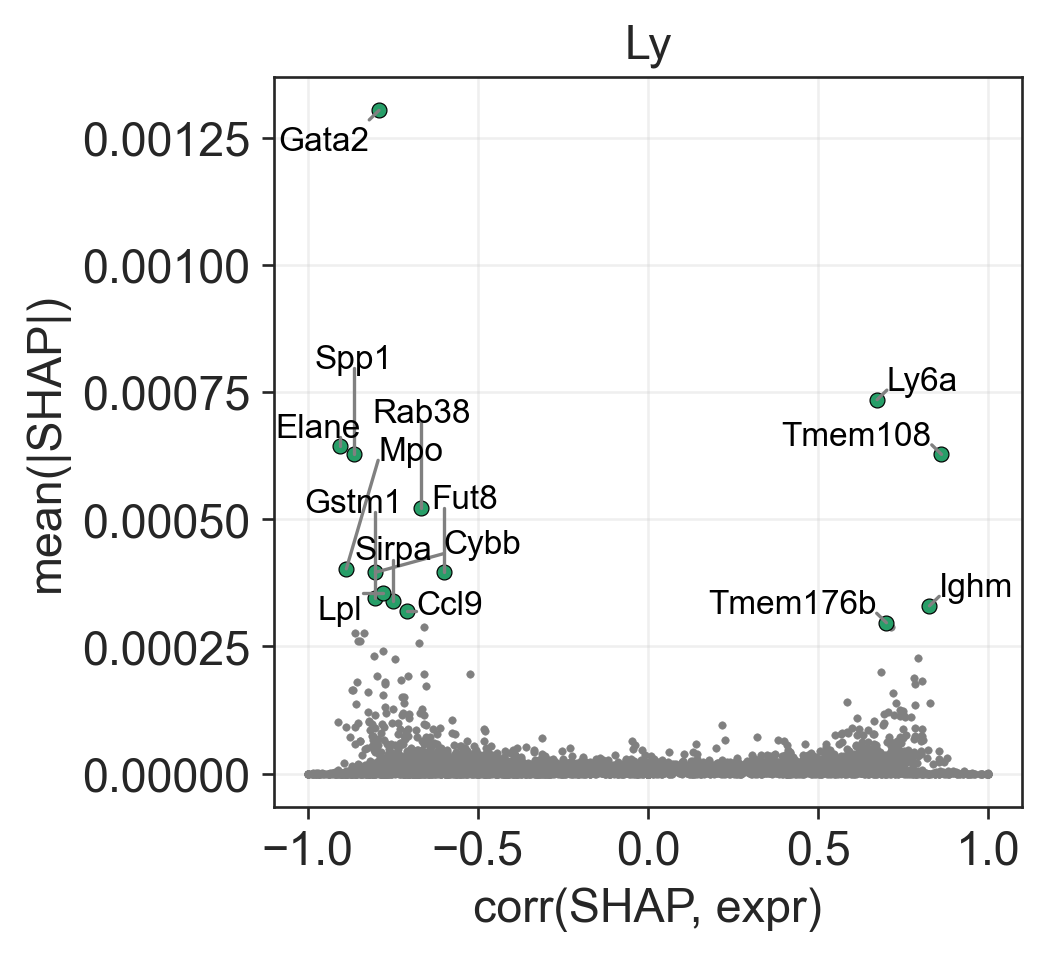

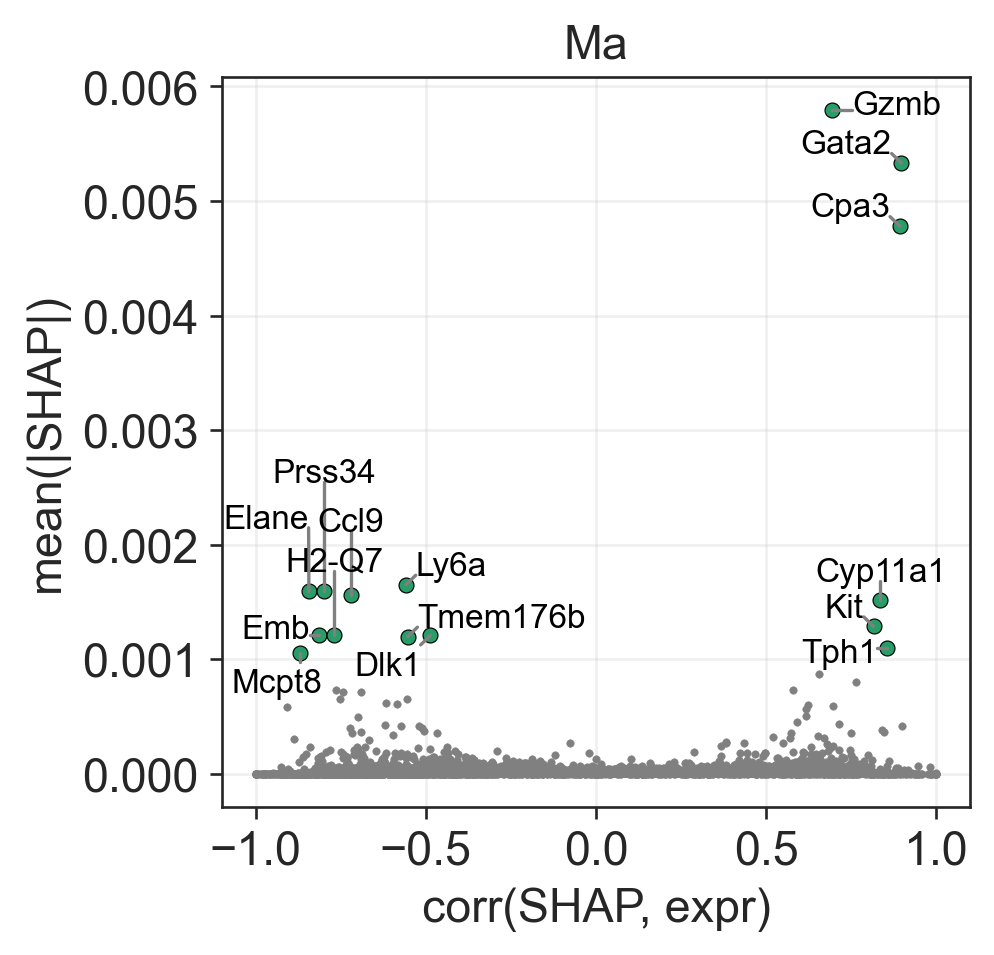

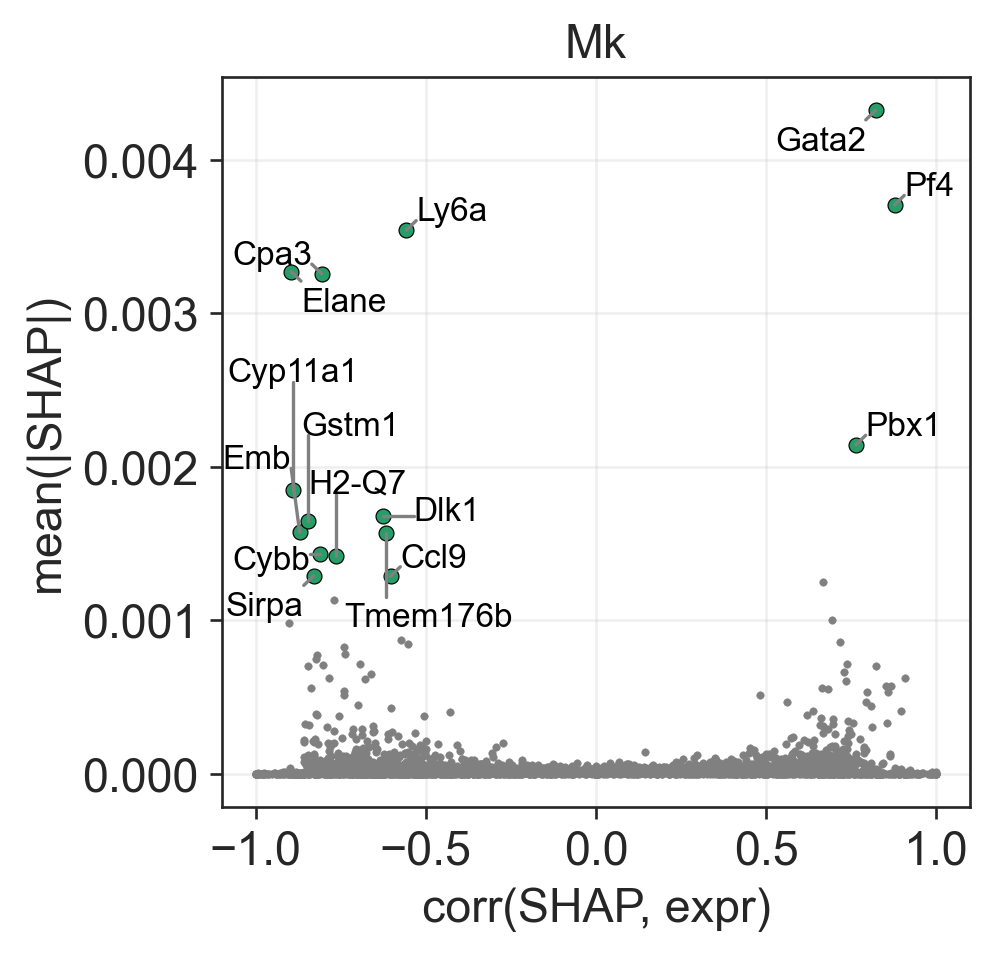

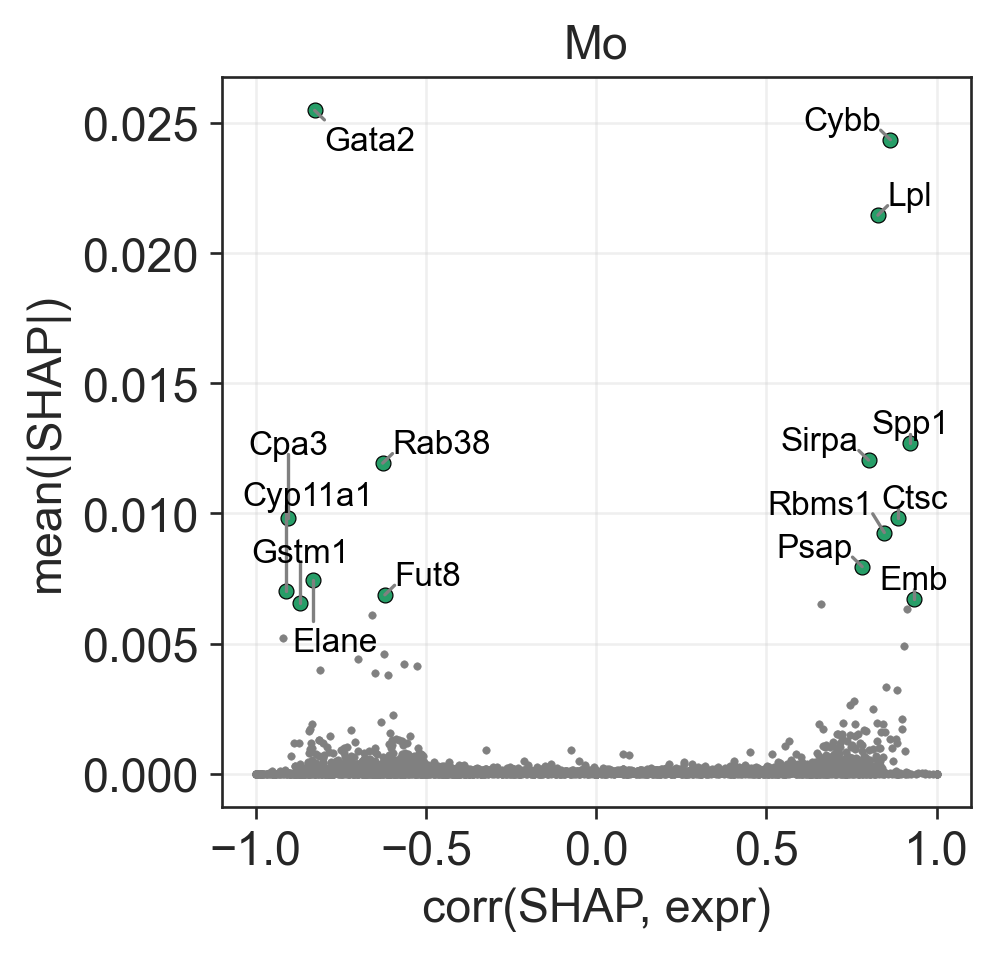

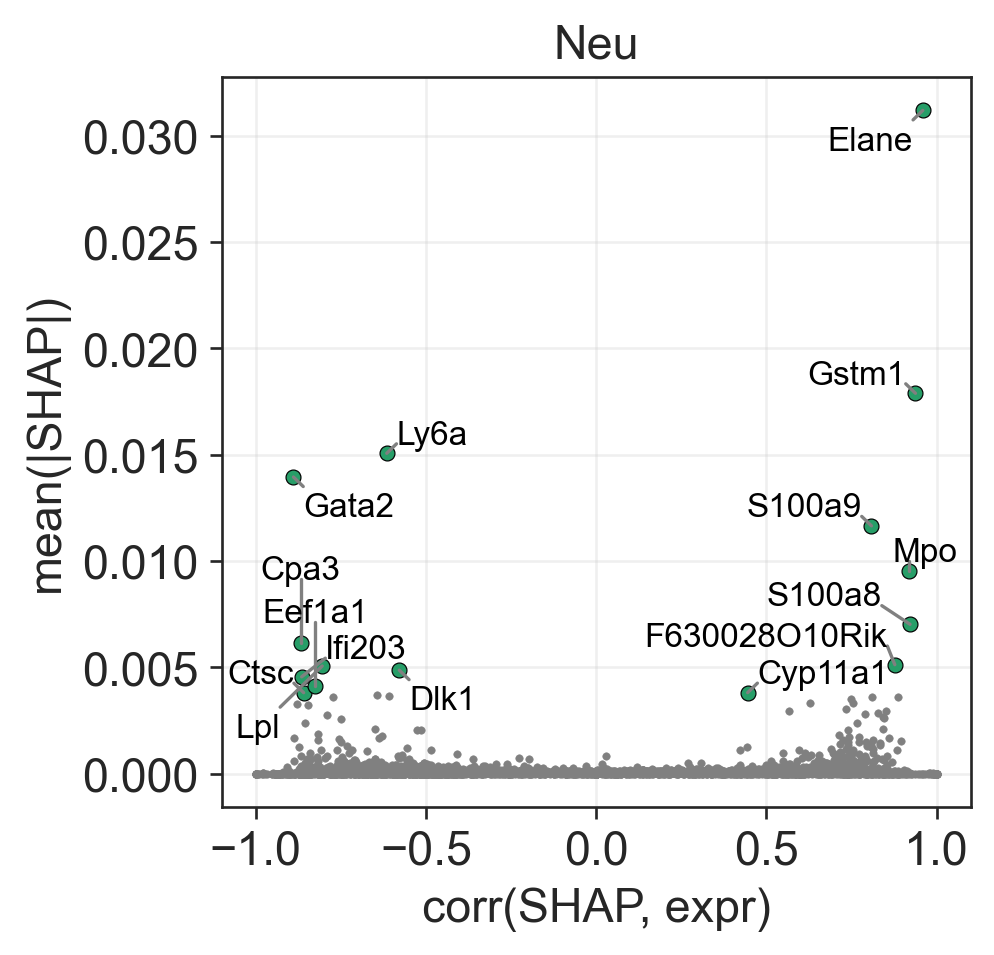

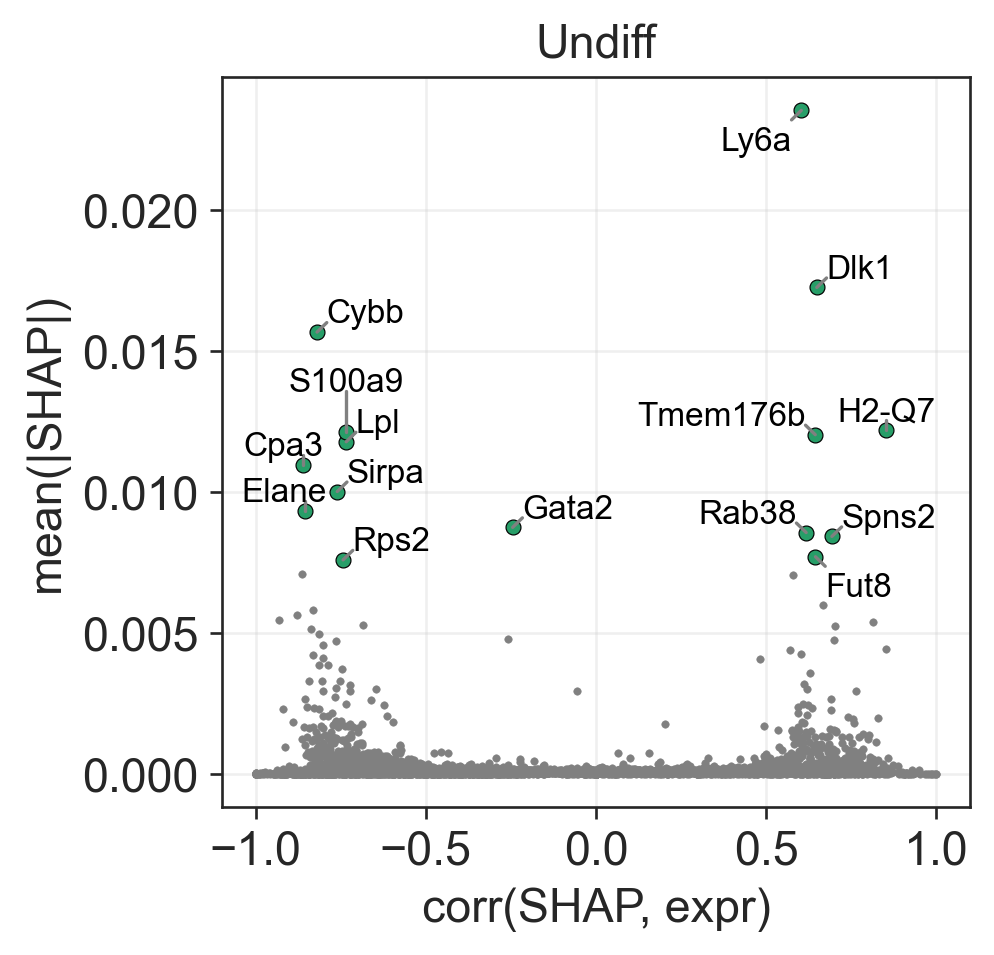

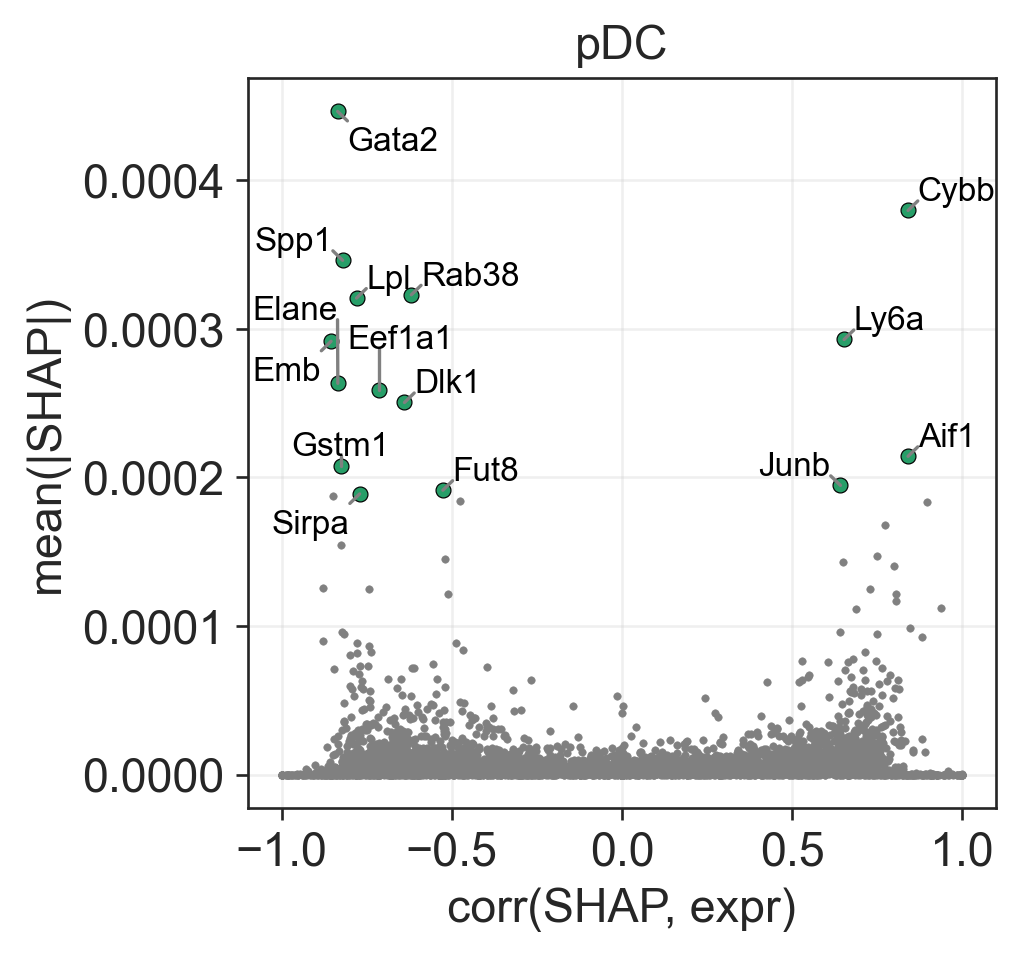

In [103]:
import textalloc as ta

n_genes = 15

for ct in clones.var_names:
    fig, ax = plt.subplots(figsize=(4, 4))
    
    df = pd.DataFrame({
        "shap_correlation": shapdata_ct.var[f"shap_corr_{ct}"].values,
        "mean_shap_mag": np.abs(shapdata_ct.layers[f"shap_{ct}"]).mean(axis=0).A[0],
    }, index=shapdata_ct.var_names)

    sns.scatterplot(
        x="shap_correlation",
        y="mean_shap_mag",
        data=df,
        edgecolor=None,
        s=5,
        color="grey",
        ax=ax,
    )

    # Top-predictors
    df_subset = df.loc[df.mean_shap_mag.sort_values()[-n_genes:].index]
    sns.scatterplot(
        x="shap_correlation",
        y="mean_shap_mag",
        data=df_subset[df_subset.shap_correlation > 0],
        edgecolor="black",
        s=20,
        color=sns.color_palette()[2],
        ax=ax,
    )
    
    sns.scatterplot(
        x="shap_correlation",
        y="mean_shap_mag",
        data=df_subset[df_subset.shap_correlation < 0],
        edgecolor="black",
        s=20,
        color=sns.color_palette()[3],
        ax=ax,
    )
    
    ta.allocate(
        ax,
        x=df_subset.shap_correlation,
        y=df_subset.mean_shap_mag,
        text_list=df_subset.index,
        x_scatter=df.shap_correlation,
        y_scatter=df.mean_shap_mag,
        textsize=10,
        linecolor="grey",
    )

    ax.set_xlabel("corr(SHAP, expr)")
    ax.set_ylabel("mean(|SHAP|)")
    ax.grid(alpha=0.3)
    ax.set_title(ct)

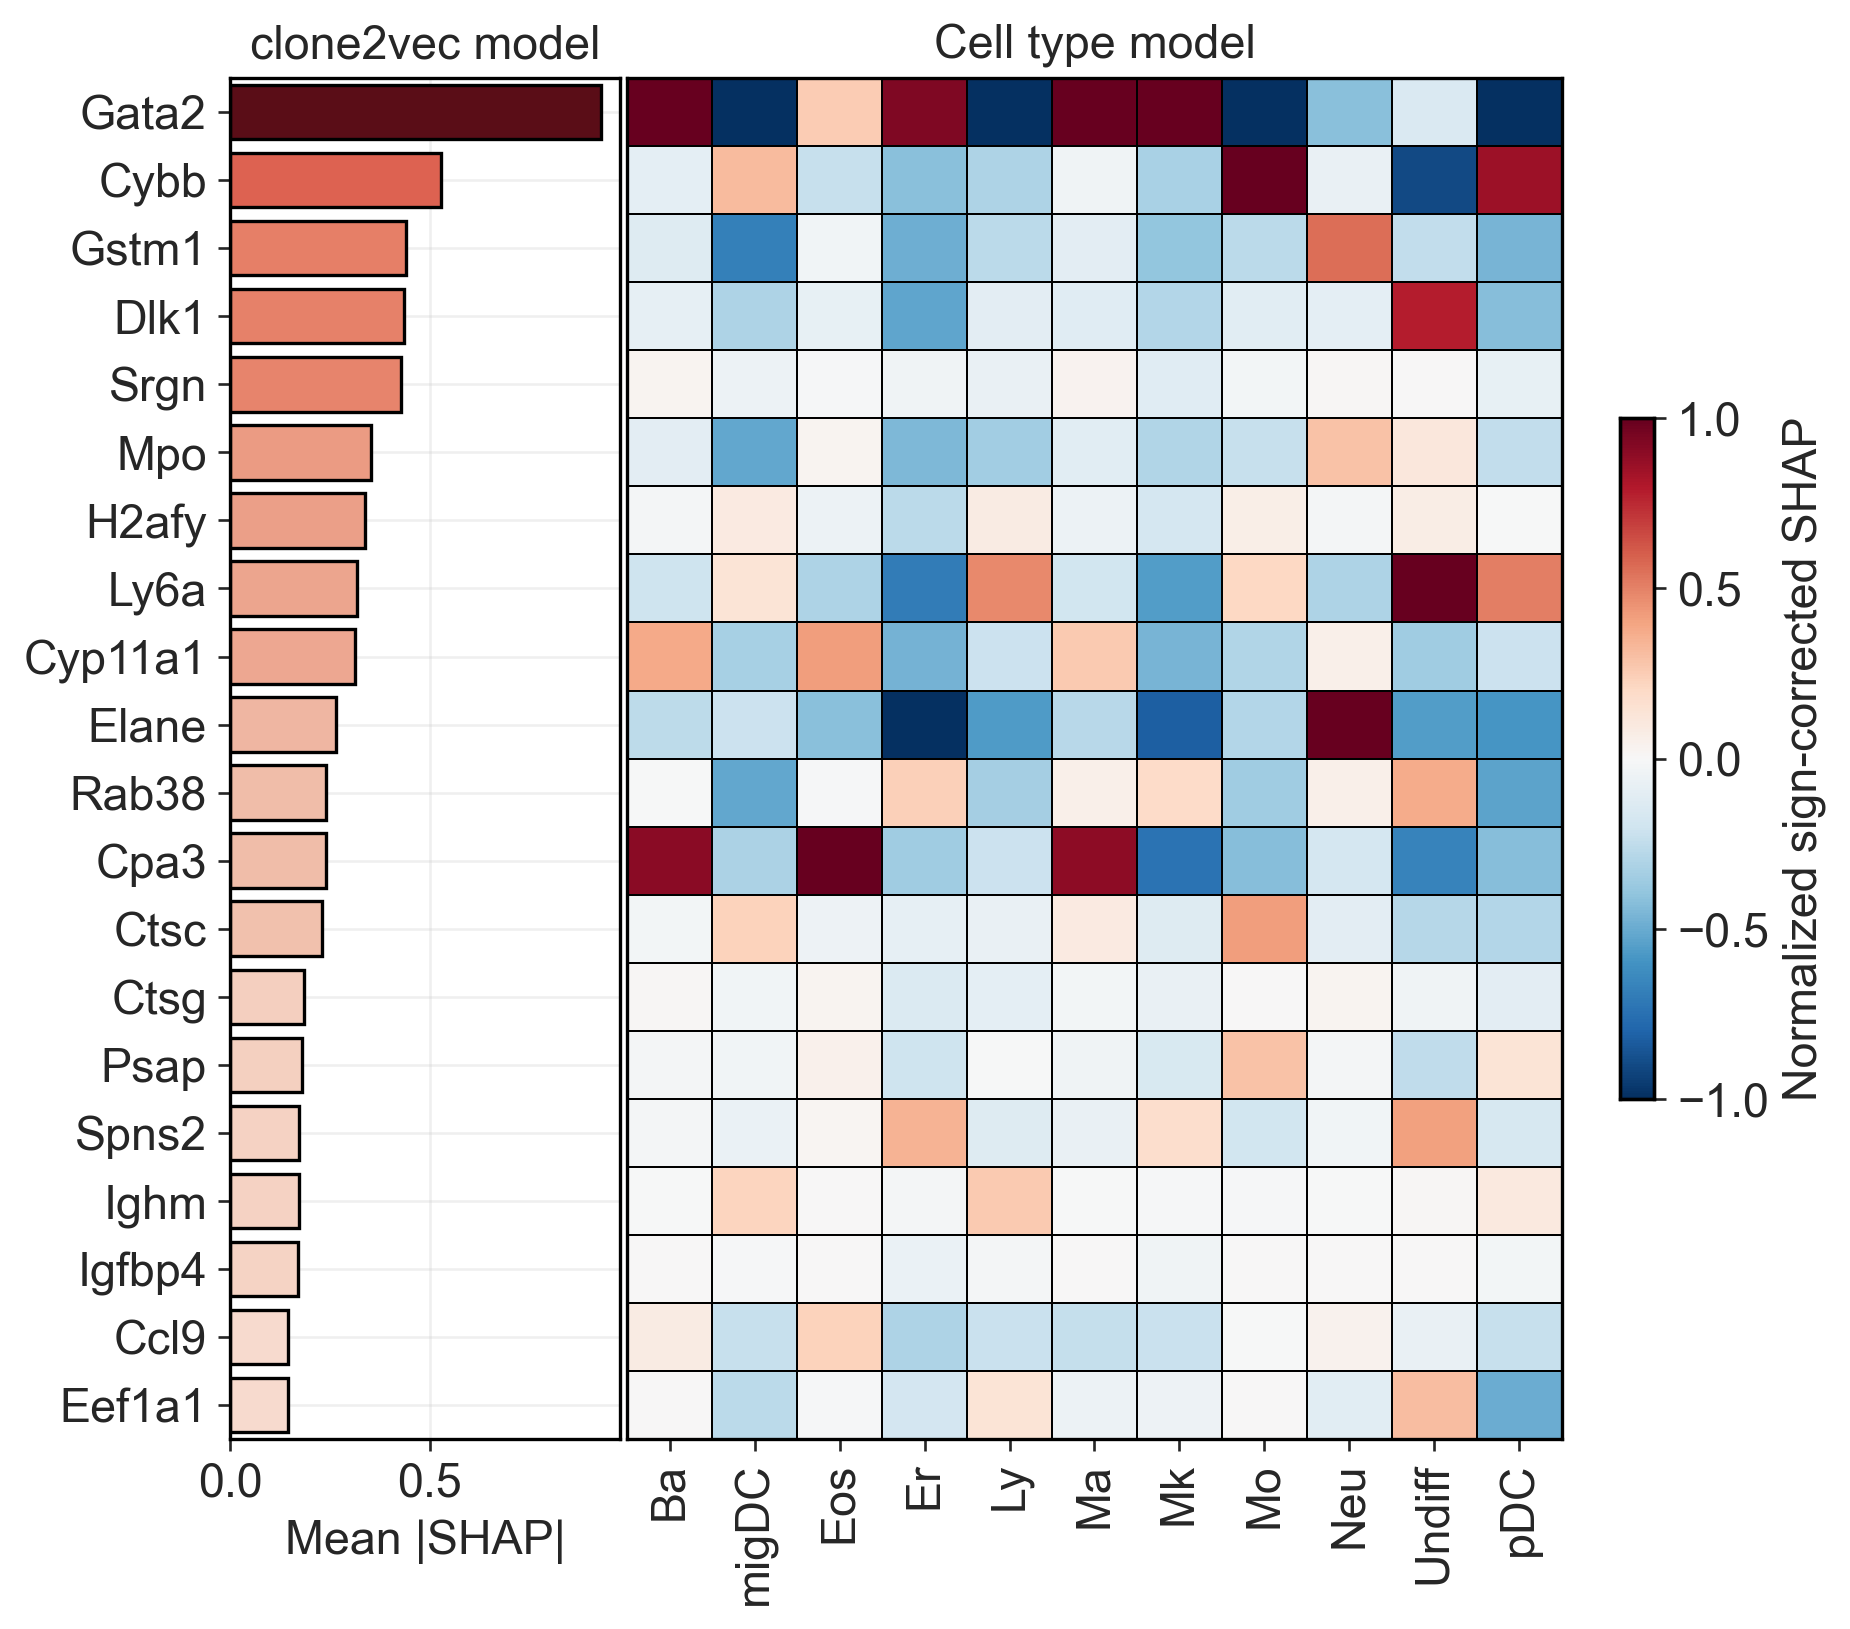

In [297]:
n_top_genes = 20
width = 8
cmap_barplot = "Reds"
cmap_heatmap = "RdBu_r"
normalize = True

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    top_genes = shapdata_c2v.var.gene_importance.sort_values(ascending=False)[:n_top_genes]
    cts = [i.split("_")[1] for i in list(shapdata_ct.layers.keys()) if "shap_" in i]

    fig, axes = plt.subplots(ncols=2, figsize=(width, 0.35 * n_top_genes), gridspec_kw={"width_ratios": [1, 3]})

    # Plotting of the clone2vec SHAP values

    # Create a colorscheme
    norm = plt.Normalize(0, top_genes.max())
    sm = plt.cm.ScalarMappable(cmap=cmap_barplot, norm=norm)
    bar_colors = plt.cm.get_cmap(cmap_barplot)(norm(top_genes))[::-1]

    sns.barplot(
        x=top_genes,
        y=top_genes.index,
        ax=axes[0],
        hue=top_genes.values,
        edgecolor="k",
        palette=bar_colors,
    )
    axes[0].grid(alpha=0.3)
    axes[0].set_xlabel("Mean |SHAP|")
    axes[0].set_ylabel("")
    axes[0].legend_.remove()
    axes[0].set_title("clone2vec model")
    
    for spine in axes[0].spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor("k")

    heatmap = {}
    for ct in cts:
        heatmap[ct] = (
            np.abs(shapdata_ct[:, top_genes.index].layers[f"shap_{ct}"]).mean(axis=0).A[0] *
            shapdata_ct[:, top_genes.index].var[f"shap_corr_{ct}"].values
        )
        
    heatmap = pd.DataFrame(heatmap, index=top_genes.index)
    if normalize:
        heatmap = heatmap / np.abs(heatmap).max(axis=0)
    
    sns.heatmap(heatmap, cmap=cmap_heatmap, vmin=-heatmap.max().max(), ax=axes[1],
                linecolor="k", linewidth=0.5, cbar_kws={"shrink": 0.5})
    axes[1].set_yticks([], [])
    
    for spine in axes[1].spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor("k")
        
    cbar = axes[1].collections[0].colorbar

    # Style the colorbar's border (spines)
    for spine in cbar.ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor("k")
        
    axes[1].set_title("Cell type model")
    if normalize:
        cbar.set_label("Normalized sign-corrected SHAP")
    else:
        cbar.set_label("Sign-corrected SHAP")
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.01)

In [302]:
clones_expr = sl.tl.summarize_expression(adata, clones, obs_name="Clone", subset_obs="Cell type annotation short",
                                         target_value="Undiff")
clones_expr = clones_expr[clones[:, "Undiff"].X.T[0] > 0]

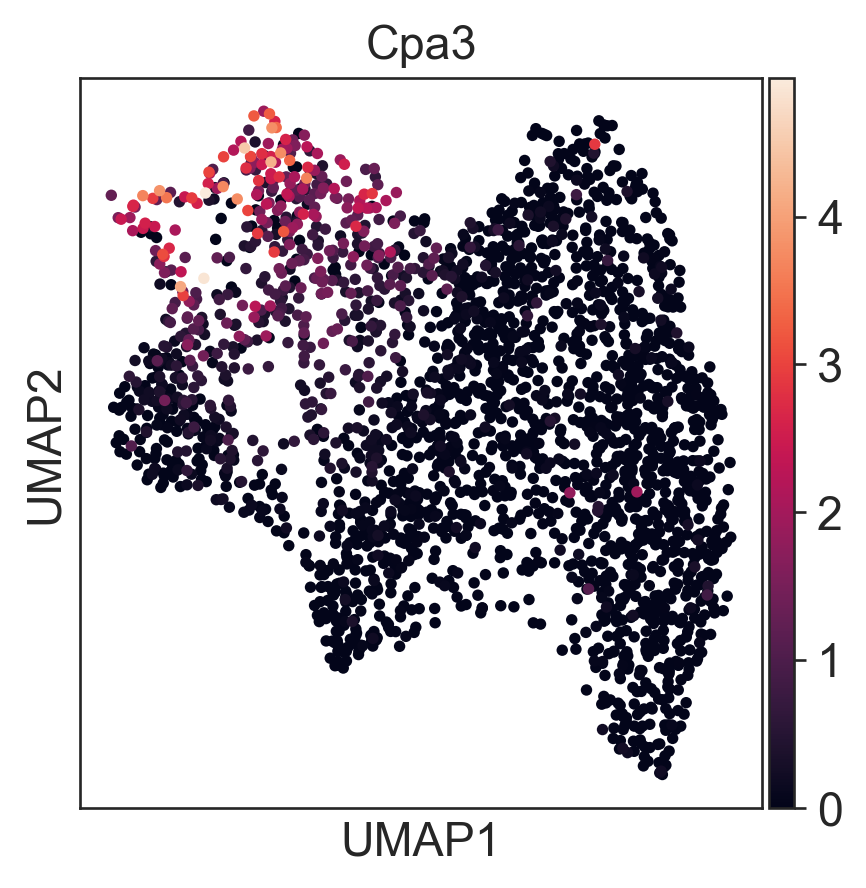

In [327]:
gene = "Cpa3"

sc.pl.umap(clones_expr, color=gene, vmin=0)

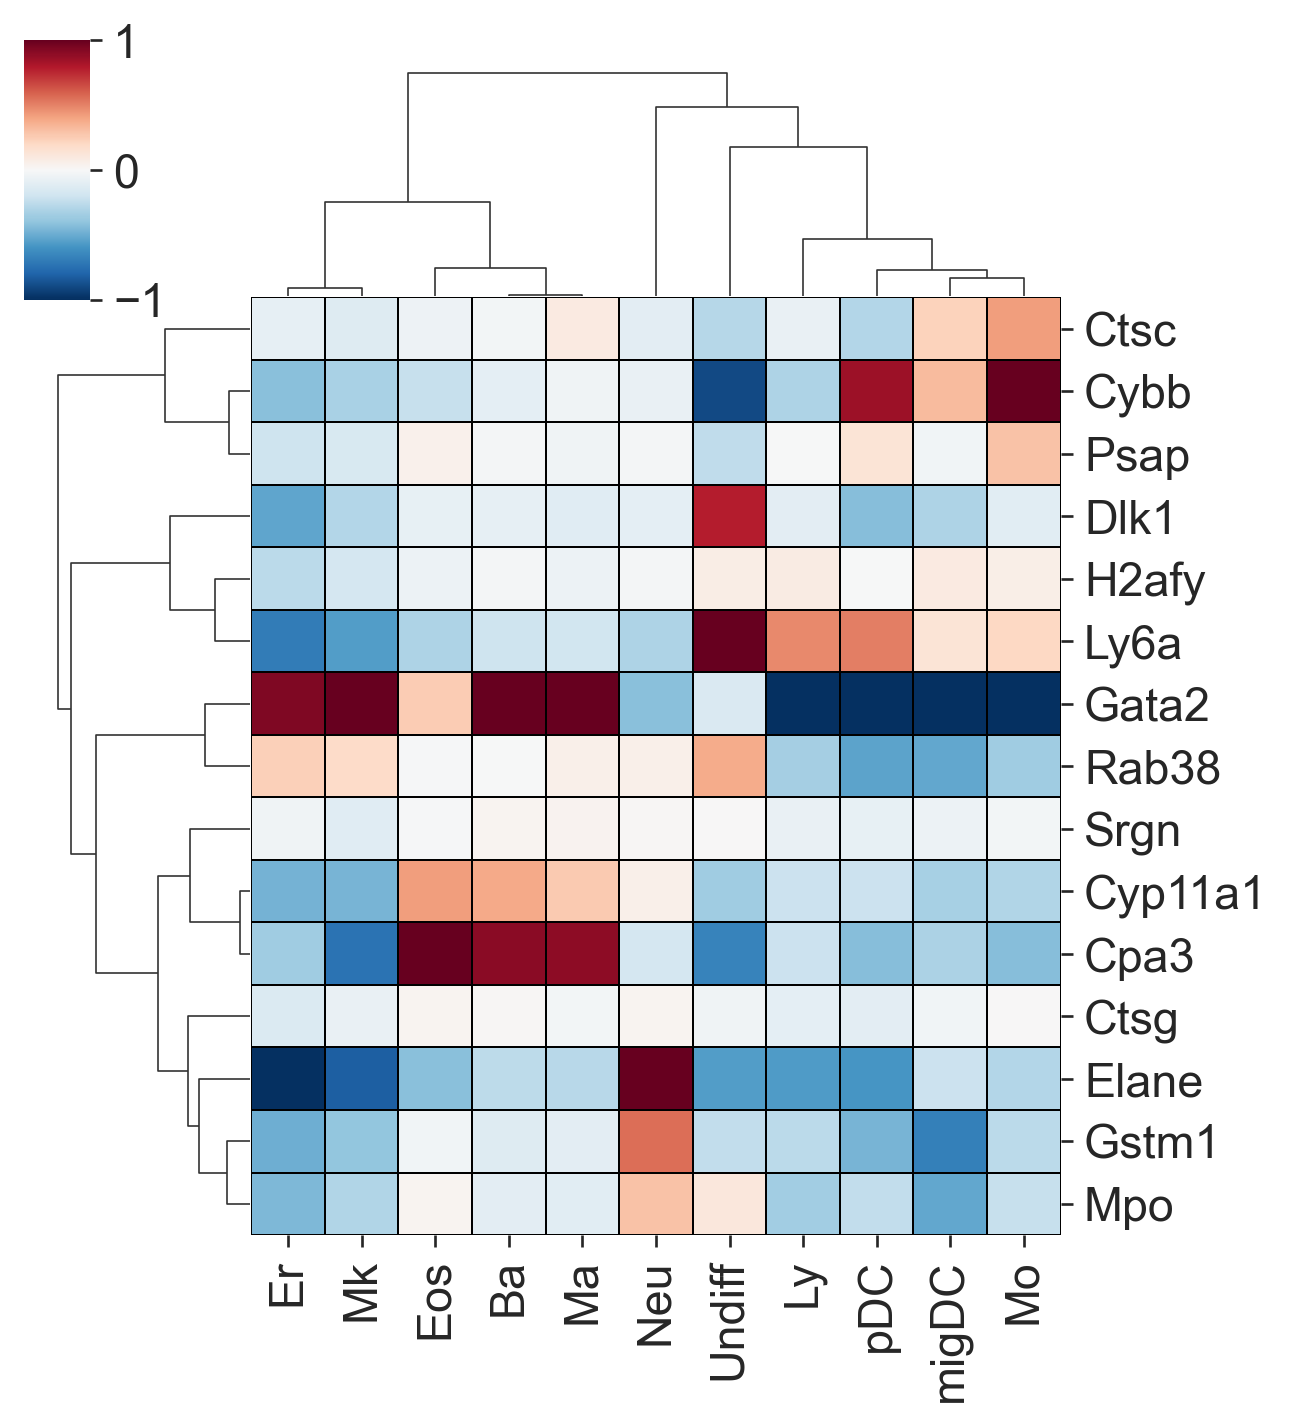

In [291]:
sns.clustermap(heatmap, cmap="RdBu_r", figsize=(5.5, 6), linecolor="k",
               linewidth=0.5, metric="correlation")